## Import Dependencies

In [1]:
%%time

import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.bo_functions_generic import gen_theta_set, clean_1D_arrays
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
import pickle

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CPU times: user 2.37 s, sys: 459 ms, total: 2.83 s
Wall time: 4.62 s


## Define Case Study Simulator & Functions

In [2]:
def simulator_helper_test_fxns(cs_name, indecies_to_consider, noise_mean, noise_std, normalize, seed):
    """
    Sets the model for calculating y based off of the case study identifier.

    Parameters
    ----------
    cs_name: Class, The name/enumerator associated with the case study being evaluated

    Returns
    -------
    calc_y_fxn: function, the function used for calculation is case study cs_name.name
    """
    #Note: Add your function name from GPBO_Class_fxns.py here
    if cs_name.value == 1:      
        theta_names = ['theta_1', 'theta_2']
        bounds_x_l = [-2]
        bounds_x_u = [2]
        bounds_theta_l = [-2, -2]
        bounds_theta_u = [ 2,  2]
        theta_ref = np.array([1.0, -1.0])     
        calc_y_fxn = calc_cs1_polynomial
        
    elif cs_name.value == 2:                          
        theta_names = ['A_1', 'A_2', 'A_3', 'A_4', 'a_1', 'a_2', 'a_3', 'a_4', 'b_1', 'b_2', 'b_3', 'b_4', 'c_1', 
                       'c_2', 'c_3', 'c_4', 'x0_1', 'x0_2', 'x0_3', 'x0_4', 'x1_1', 'x1_2', 'x1_3', 'x1_4']
        bounds_x_l = [-1.5, -0.5]
        bounds_x_u = [1, 2]
        bounds_theta_l = [-300,-200,-250, 5,-2,-2,-10, -2, -2,-2,5,-2,-20,-20, -10,-1 ,-2,-2,-2, -2,-2,-2,0,-2]
        bounds_theta_u = [-100,  0, -150, 20,2, 2, 0,  2,  2,  2, 15,2, 0,0   , 0,  2, 2,  2, 2, 2 ,2 , 2, 2,2]
        theta_ref = np.array([-200,-100,-170,15,-1,-1,-6.5,0.7,0,0,11,0.6,-10,-10,-6.5,0.7,1,0,-0.5,-1,0,0.5,1.5,1])      
#         theta_ref = np.array([0.5, 0.5, 0.8, 2/3, 0.25, 0.25, 0.35, 0.675, 0.5, 0.5, 0.6, 0.65, 0.5, 0.5, 0.35, 28333/50000, 0.75, 0.5,
#     0.375, 0.25, 0.5, 0.625, 0.75, 0.75])
        calc_y_fxn = calc_muller
        
    else:
        raise ValueError("self.CaseStudyParameters.cs_name.value must exist!")

    return Simulator(indecies_to_consider, 
                     theta_ref,
                     theta_names,
                     bounds_theta_l, 
                     bounds_x_l, 
                     bounds_theta_u, 
                     bounds_x_u, 
                     noise_mean,
                     noise_std,
                     normalize,
                     seed,
                     calc_y_fxn)

## Define Method and DateTime

In [3]:
#Generate Method (except last part)
meth_name = Method_name_enum(5)
method = GPBO_Methods(meth_name)

print("Method Name: ", method.method_name.name)
print("Emulator?: ", method.emulator)
print("Obj Func: ", method.obj.name)
print("Sparse Grid?: ", method.sparse_grid)

#Set Date and Time
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d-%b-%Y (%H:%M:%S)")
# print("Date and Time: ", timestampStr)
# DateTime = dateTimeObj.strftime("%Y/%m/%d/%H-%M-%S%p")
DateTime = dateTimeObj.strftime("%Y/%m/%d/%H-%M")
DateTime = None ##For Testing

Method Name:  C2
Emulator?:  True
Obj Func:  OBJ
Sparse Grid?:  True


# Case Study GPBO Driver Test

In [4]:
cs_name  = CS_name_enum(1)
print("CS Name: ", cs_name.name)

# indecies_to_consider = list(range(2, 6)) #This is what changes for different subproblems of CS2
indecies_to_consider = list(range(0, 2)) #This is what changes for different subproblems of CS1

ep0 = 1
ep_enum = Ep_enum(1)
sep_fact = 0.8
normalize = False
gen_heat_map_data = True
noise_mean = 0
noise_std = 0.01
# noise_std = 0.0
kernel = Kernel_enum(1)
lenscl = None
outputscl = 1
retrain_GP = 1
reoptimize_obj = 1
bo_iter_tot = 3
bo_run_tot = 2
save_data = True
seed = 1
ei_tol = 1e-6
obj_tol = 1e-4

num_x_data = 5
gen_meth_x = Gen_meth_enum(2) #Note: Has to be the same for validation and sim data
num_theta_data = 20
gen_meth_theta = Gen_meth_enum(1)
num_theta_data_val = 10
gen_meth_theta_val = Gen_meth_enum(1)

CS Name:  CS1


In [5]:
#Set Cs_params and Simulator
cs_params = CaseStudyParameters(cs_name, ep0, sep_fact, normalize, kernel, lenscl, outputscl, retrain_GP, 
                                reoptimize_obj, gen_heat_map_data, bo_iter_tot, bo_run_tot, save_data, DateTime, 
                                seed, ei_tol, obj_tol)
simulator = simulator_helper_test_fxns(cs_name, indecies_to_consider, noise_mean, noise_std, normalize, seed)

#Generate Exp Data
exp_data = simulator.gen_exp_data(num_x_data, gen_meth_x)

#Generate Sim Data
sim_data = simulator.gen_sim_data(num_theta_data, num_x_data, gen_meth_theta, gen_meth_x, sep_fact, False)
sim_sse_data = simulator.sim_data_to_sse_sim_data(method, sim_data, exp_data, sep_fact, False)

#Generate Validation Data
val_data = simulator.gen_sim_data(num_theta_data_val, num_x_data, gen_meth_theta_val, gen_meth_x, sep_fact, True)
val_sse_data = simulator.sim_data_to_sse_sim_data(method, val_data, exp_data, sep_fact, True)

#Set Ep_Bias
if ep_enum.value == 1:
    ep_bias = Exploration_Bias(ep0, None, ep_enum, None, None, None, None, None, None, None)
elif ep_enum.value == 2:
    ep_bias = Exploration_Bias(ep0, None, ep_enum, None, bo_iter_tot, None, 0, None, None, None)
elif ep_enum.value == 3:
    ep_bias = Exploration_Bias(ep0, None, ep_enum, None, None, 1.5, None, None, None, None)
else:
    ep_bias = Exploration_Bias(None, None, ep_enum, None, None, None, None, None, None, None)

#Initialize Driver
driver = GPBO_Driver(cs_params, method, simulator, exp_data, sim_data, sim_sse_data, val_data, val_sse_data, None, 
                     ep_bias, gen_meth_theta_val)

In [6]:
#Run Bo iterations/restarts
restart_bo_results = driver.run_bo_restarts()

In [7]:
#Open Data File
name_cs_str = "CS1"
fileObj = open("No_Date/Data_Files/" + name_cs_str + ".pickle", 'rb')
loaded_results = pickle.load(fileObj)
fileObj.close()

#Define the run number and bo iter in question and pull the max bo iters and runs
run_num = 0
bo_iter = 0
runs = loaded_results[run_num].simulator.["Number of Workflow Restarts"]
num_sets = loaded_results[run_num].configuration["Max BO Iters"]

#Print Results
print(loaded_results[run_num].configuration)
# print(loaded_results[run_num].list_gp_emulator_class[bo_iter])
# print(len(loaded_results[run_num].list_heat_map_data))
print(loaded_results[run_num].results_df)
print(loaded_results[run_num].results_df["Theta Min Obj Cum."].iloc[-1])
print(loaded_results[run_num].simulator_class.theta_true)
# print(loaded_results[run_num].heat_map_data_dict)
# print(loaded_results[run_num].simulator_class.theta_true_norm)

{'DateTime String': None, 'Method Name Enum Value': 5, 'Case Study Name': 'CS1', 'Exploration Bias Method Value': 1, 'Separation Factor': 0.8, 'Normalize': False, 'Initial Kernel': <Kernel_enum.MAT_52: 1>, 'Initial Lengthscale': None, 'Initial Outputscale': 1, 'Retrain GP': 1, 'Reoptimize Obj': 1, 'Heat Map Points Generated': True, 'Max BO Iters': 3, 'Number of Workflow Restarts': 2, 'Seed': 1, 'EI Tolerance': 0.0001, 'Obj Improvement Tolerance': 1e-06}
   index Best Error Exploration Bias Max EI  \
0      0   9.650632                1    0.0   
1      0   9.650632                1    0.0   

                                Theta Max EI   Min Obj  \
0  [-0.5099877471624152, -0.262973205950237]   0.00039   
1  [-1.424906265112171, 0.33997509467786546]  0.000531   

                               Theta Min Obj Min Obj Cum.  \
0  [0.9946435749667555, -0.9935658169599941]      0.00039   
1  [0.9932180420873663, -0.9930703838129037]      0.00039   

                          Theta Min Obj C

## Plot BO Result Data

In [8]:
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import *
title_fontsize = 24
other_fontsize = 20
save_path = None

dim_hps = len(loaded_results[run_num].list_gp_emulator_class[run_num].trained_hyperparams[run_num]) + 2
hps = np.zeros((runs, num_sets, dim_hps))
hp_names = [f"\\ell_{i}" for i in range(1, dim_hps+1)]
hp_names[-2] = "\sigma"
hp_names[-1] = "\\tau"
data_true = None

for j in range(runs):
    run = loaded_results[j]
    for i in range(len(run.list_gp_emulator_class)):
       # Extract the array and convert other elements to float
        array_part = run.list_gp_emulator_class[i].trained_hyperparams[0]
        rest_part = np.array(run.list_gp_emulator_class[i].trained_hyperparams[1:], dtype=float)
        hp = np.concatenate([array_part, rest_part])
        # Create the resulting array of shape (1, 10)
        hps[j,i,:] = hp

In [9]:
xbins = 5
ybins = 7

x_label = "BO Iterations"
y_label = "Hyperparameters"
title = "Hyperparameter Values"
# plot_2D_Data(hps, hp_names, data_true, xbins, ybins, title, x_label, y_label, title_fontsize, other_fontsize, save_path)

In [10]:
dim_data = 3 #obj, min obj, and ei
data = np.zeros((runs, num_sets, dim_data))
data_names = ["log(sse)", "min(log(sse))", "EI"]
data_true = None

for j in range(runs):
    run = loaded_results[j]
    # Extract the array and convert other elements to float
    for i in range(len(run.results_df["Min Obj"])):
        log_sse = np.log(run.results_df["Min Obj"].to_numpy().astype(float)[i])
        log_min_sse = np.log(run.results_df["Min Obj Cum."].to_numpy().astype(float)[i])
        max_ei = run.results_df["Max EI"].to_numpy().astype(float)[i]
        # Create the resulting array of shape (1, 10)
        data[j,i,0] = log_sse
        data[j,i,1] = log_min_sse
        data[j,i,2] = max_ei

In [11]:
xbins = 5
ybins = 7

x_label = "BO Iterations"
y_label = "Data"
title = "Data Values"
# plot_2D_Data(data, data_names, data_true, xbins, ybins, title, x_label, y_label, title_fontsize, other_fontsize, save_path)

In [12]:
dim_data = len(loaded_results[run_num].results_df["Theta Min Obj"].to_numpy()[0]) #len theta best

data = np.zeros((runs, num_sets, dim_data))
data_names = [f"\\theta_{i}" for i in range(1, dim_data+1)]
data_true = loaded_results[run_num].simulator_class.theta_true
for j in range(runs):
    run = loaded_results[j]
    num_iters = len(run.results_df["Theta Min Obj"])
    for i in range(num_iters):
        # Extract the array and convert other elements to float
        theta_min_obj = run.results_df["Theta Min Obj"].to_numpy()[i]
        # Create the resulting array of shape (1, 10)
        data[j,i,:] = theta_min_obj

In [13]:
xbins = 5
ybins = 5

x_label = "BO Iterations"
y_label = "Theta Values"
title = "Min Obj Parameter Values"
# plot_2D_Data(data, data_names, data_true, xbins, ybins, title, x_label, y_label, title_fontsize, other_fontsize, save_path)

In [14]:
dim_data = len(loaded_results[0].results_df["Theta Min Obj Cum."].to_numpy()[0]) #len theta best
data = np.zeros((runs, num_sets, dim_data))
data_names = [f"\\theta_{i}" for i in range(1, dim_data+1)]
data_true = loaded_results[run_num].simulator_class.theta_true

for j in range(runs):
    run = loaded_results[j]
    num_iters = len(run.results_df["Theta Min Obj Cum."])
    for i in range(num_iters):
        # Extract the array and convert other elements to float
        theta_min_obj = run.results_df["Theta Min Obj Cum."].to_numpy()[i]
        # Create the resulting array of shape (1, 10)
        data[j,i,:] = theta_min_obj

In [15]:
xbins = 5
ybins = 5

x_label = "BO Iterations"
y_label = "Theta Values"
title = "Min Obj Parameter Values Overall"
# plot_2D_Data(data, data_names, data_true, xbins, ybins, title, x_label, y_label, title_fontsize, other_fontsize, save_path)

In [16]:
dim_data = len(loaded_results[run_num].results_df["Theta Max EI"].to_numpy()[0]) #len theta best
data = np.zeros((runs, num_sets, dim_data))
data_names = [f"\\theta_{i}" for i in range(1, dim_data+1)]
data_true = loaded_results[run_num].simulator_class.theta_true

for j in range(runs):
    run = loaded_results[j]
    num_iters = len(run.results_df["Theta Max EI"])
    for i in range(num_iters):
        # Extract the array and convert other elements to float
        theta_min_obj = run.results_df["Theta Max EI"].to_numpy()[i]
        # Create the resulting array of shape (1, 10)
        data[j,i,:] = theta_min_obj

In [17]:
xbins = 5
ybins = 5

x_label = "BO Iterations"
y_label = "Theta Values"
title = "Max EI Parameter Values"
# plot_2D_Data(data, data_names, data_true, xbins, ybins, title, x_label, y_label, title_fontsize, other_fontsize, save_path)

In [18]:
x_exp = loaded_results[run_num].exp_data_class.x_vals
dim_data = loaded_results[run_num].list_gp_emulator_class[run_num].get_dim_gp_data() #dim training data
data_true = loaded_results[run_num].simulator_class.theta_true

param_names = [f"\\theta_{i}" for i in range(1, len(data_true)+1)]
x_names = [f"Xexp_{i}" for i in range(1, x_exp.shape[1]+1)]
data_names = param_names+x_names

train_data = loaded_results[run_num].list_gp_emulator_class[bo_iter].feature_train_data
test_data = loaded_results[run_num].list_gp_emulator_class[bo_iter].feature_test_data
val_data = loaded_results[run_num].list_gp_emulator_class[bo_iter].feature_val_data

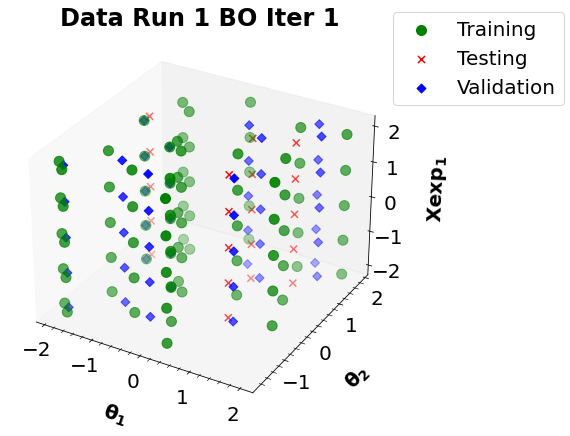

In [19]:
xbins = 5
ybins = 5
zbins = 5

idcs_to_plot = [0,1,2]

title = "Data Run 1 BO Iter 1"

data_true = loaded_results[0].simulator_class.theta_true
plot_train_test_val_data(train_data, test_data, val_data, data_names, idcs_to_plot, x_exp, xbins, ybins, zbins, 
                         title, title_fontsize, other_fontsize, save_path)

## Plot Heat Maps

In [20]:
fileObj = open("No_Date/Data_Files/"+ name_cs_str + ".pickle", 'rb')
# fileObj = open("No_Date/Data_Files/"+ "CS1" + ".pickle", 'rb')
loaded_results = pickle.load(fileObj)
fileObj.close()

print(loaded_results[run_num].configuration)
print(loaded_results[run_num].results_df)

{'DateTime String': None, 'Method Name Enum Value': 5, 'Case Study Name': 'CS1', 'Exploration Bias Method Value': 1, 'Separation Factor': 0.8, 'Normalize': False, 'Initial Kernel': <Kernel_enum.MAT_52: 1>, 'Initial Lengthscale': None, 'Initial Outputscale': 1, 'Retrain GP': 1, 'Reoptimize Obj': 1, 'Heat Map Points Generated': True, 'Max BO Iters': 3, 'Number of Workflow Restarts': 2, 'Seed': 1, 'EI Tolerance': 0.0001, 'Obj Improvement Tolerance': 1e-06}
   index Best Error Exploration Bias Max EI  \
0      0   9.650632                1    0.0   
1      0   9.650632                1    0.0   

                                Theta Max EI   Min Obj  \
0  [-0.5099877471624152, -0.262973205950237]   0.00039   
1  [-1.424906265112171, 0.33997509467786546]  0.000531   

                               Theta Min Obj Min Obj Cum.  \
0  [0.9946435749667555, -0.9935658169599941]      0.00039   
1  [0.9932180420873663, -0.9930703838129037]      0.00039   

                          Theta Min Obj C

In [21]:
#Create Heat Map Data for a run and iter
# pair = "a_1-a_2"
#Just choose the 1st key for example purposes
pair = list(loaded_results[run_num].heat_map_data_dict.keys())[0]

#Regeneate simulator, gp_emulator, exerimental data, best error, true theta, lowest obj theta, and highest ei theta
gp_emulator = loaded_results[run_num].list_gp_emulator_class[bo_iter]
heat_map_data_dict = loaded_results[run_num].heat_map_data_dict
heat_map_data = heat_map_data_dict[pair]
featurized_hm_data = gp_emulator.featurize_data(heat_map_data)
simulator = loaded_results[run_num].simulator_class
param_names = pair
#Get index of param set
idcs_to_plot = [loaded_results[run_num].simulator_class.theta_true_names.index(name) for name in param_names]
exp_data = loaded_results[run_num].exp_data_class
best_error =  loaded_results[run_num].results_df["Best Error"].iloc[bo_iter]
theta_true = loaded_results[run_num].simulator_class.theta_true
theta_opt =  loaded_results[run_num].results_df["Theta Min Obj Cum."].iloc[bo_iter]
theta_next = loaded_results[run_num].results_df["Theta Max EI"].iloc[bo_iter]
train_theta = loaded_results[run_num].list_gp_emulator_class[bo_iter].train_data.theta_vals
enum_method = loaded_results[run_num].configuration["Method Name Enum Value"]
enum_ep = Ep_enum(loaded_results[run_num].configuration["Exploration Bias Method Value"])
sep_fact = loaded_results[run_num].configuration["Separation Factor"]
seed = loaded_results[run_num].configuration["Seed"]
ep_at_iter = loaded_results[run_num].results_df["Exploration Bias"].iloc[bo_iter]
meth_name = Method_name_enum(enum_method)
method = GPBO_Methods(meth_name)
ep_bias = Exploration_Bias(None, ep_at_iter, enum_ep, None, None, None, None, None, None, None)

In [22]:
#Calculate GP mean and var for heat map data
heat_map_data.gp_mean, heat_map_data.gp_var = gp_emulator.eval_gp_mean_var_misc(heat_map_data, featurized_hm_data)
heat_map_data.y_vals = simulator.gen_y_data(heat_map_data, 0 , 0)
heat_map_sse_data = simulator.sim_data_to_sse_sim_data(method, heat_map_data, exp_data, sep_fact, gen_val_data = False)

#Calculate SSE, SSE var, and EI
if method.emulator == False:
    heat_map_data.sse_mean, heat_map_data.sse_var = gp_emulator.eval_gp_sse_var_misc(heat_map_data)
else:
    heat_map_data.sse_mean, heat_map_data.sse_var = gp_emulator.eval_gp_sse_var_misc(heat_map_data, exp_data)
    
if method.emulator == False:
    heat_map_data.ei = gp_emulator.eval_ei_misc(heat_map_data, exp_data, ep_bias, best_error)
else:
    heat_map_data.ei = gp_emulator.eval_ei_misc(heat_map_data, exp_data, ep_bias, best_error, method)

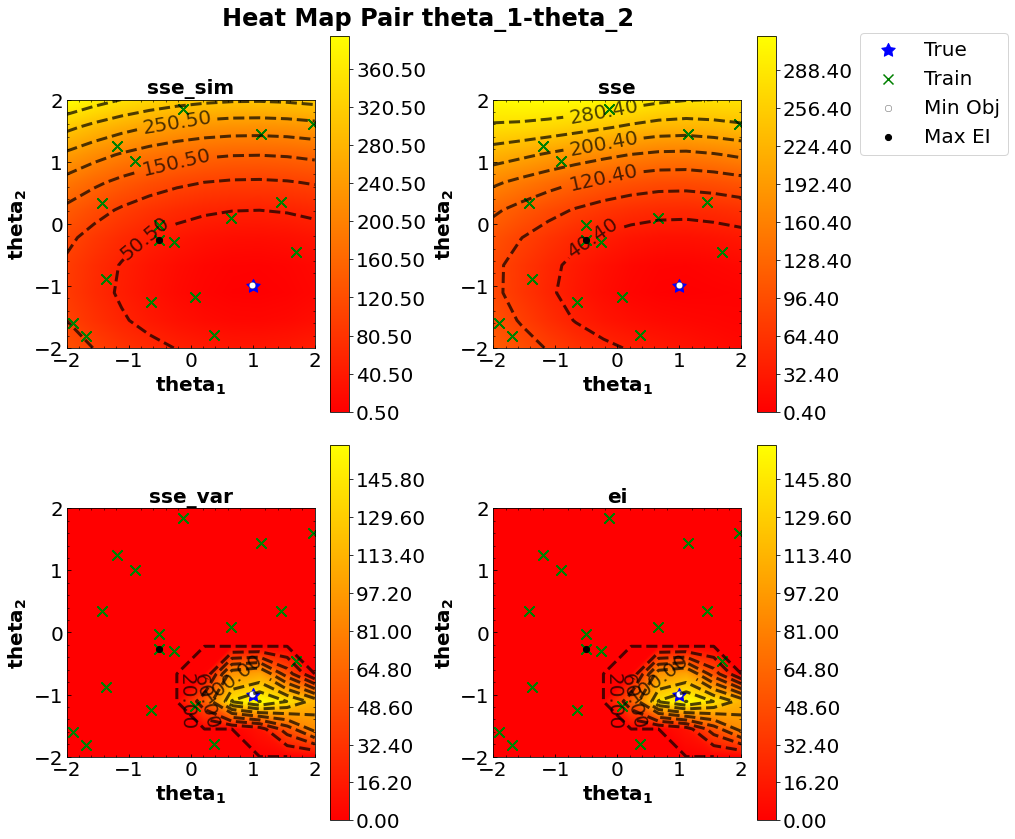

In [23]:
xbins = 4
ybins = 5
zbins = 900

#Create test mesh
#Define original theta_vals (for restoration later)
org_theta = heat_map_data.theta_vals
#Redefine the theta_vals in the given Data class to be only the 2D (varying) parts you want to plot
heat_map_data.theta_vals = heat_map_data.theta_vals[:,idcs_to_plot]
#Create a meshgrid with x and y values fron the uniwue theta values of that array
unique_theta = heat_map_data.get_unique_theta()
theta_pts = int(np.sqrt(len(unique_theta)))
test_mesh = unique_theta.reshape(theta_pts,theta_pts,-1).T
heat_map_data.theta_vals = org_theta

sse_sim = heat_map_sse_data.y_vals.reshape(theta_pts,theta_pts).T
sse_mean = heat_map_data.sse_mean.reshape(theta_pts,theta_pts).T
sse_var = heat_map_data.sse_var.reshape(theta_pts,theta_pts).T
ei = sse_var = heat_map_data.ei.reshape(theta_pts,theta_pts).T

z = [sse_sim, sse_mean, sse_var, ei]
z_titles = ["sse_sim", "sse", "sse_var", "ei"]
cmap = "autumn"
levels = [100,100,100, 100]
plot_axis_names = param_names
title = "Heat Map Pair " + "-".join(map(str, plot_axis_names))
plot_heat_maps(test_mesh, theta_true, theta_opt, theta_next, train_theta, plot_axis_names, levels, idcs_to_plot, 
               z, z_titles, xbins, ybins, zbins, title, title_fontsize, other_fontsize, cmap, save_path)

In [24]:
#Make a Data class instance with just the values you want to plot

#Generate exp_data that is pretty
num_x_data_lin = 50
gen_meth_x = Gen_meth_enum(2)
exp_data_lin = simulator.gen_exp_data(num_x_data_lin, gen_meth_x)

#Repeat the theta best array once for each x value
#Need to repeat theta_best such that it can be evaluated at every x value in exp_data using simulator.gen_y_data
theta_opt_repeated = np.repeat(theta_opt.reshape(1,-1), exp_data_lin.get_num_x_vals() , axis =0)
#Add instance of Data class to theta_best
theta_opt_data = Data(theta_opt_repeated, exp_data_lin.x_vals, None, None, None, None, None, None, 
                      simulator.bounds_theta_reg, simulator.bounds_x, sep_fact, seed)
#Calculate y values and sse for theta_best with noise
theta_opt_data.y_vals = simulator.gen_y_data(theta_opt_data, simulator.noise_mean, simulator.noise_std)  
#Calculate GP mean and var for heat map data
featurized_to_data = gp_emulator.featurize_data(theta_opt_data)
theta_opt_data.gp_mean, theta_opt_data.gp_var = gp_emulator.eval_gp_mean_var_misc(theta_opt_data, featurized_to_data)
train_data = loaded_results[run_num].list_gp_emulator_class[bo_iter].train_data
test_data = loaded_results[run_num].list_gp_emulator_class[bo_iter].test_data

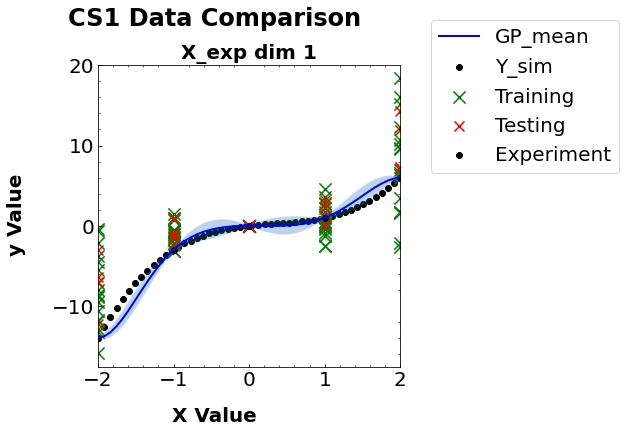

In [25]:
xbins = 5
ybins = 5
title = "CS1 Data Comparison"
x_label = "X Value"
y_label = "y Value"

plot_x_vs_y_given_theta(theta_opt_data, exp_data, train_data, test_data, xbins, ybins, title, x_label, y_label, 
                        title_fontsize, other_fontsize, save_path)

In [26]:
#Generate simulation data for x given 1 theta
simulator.seed = 4
x_val_num = 10
sim_data_x = simulator.gen_sim_data(1, x_val_num, Gen_meth_enum(1), Gen_meth_enum(2), sep_fact, False)
featurized_sim_x_data = gp_emulator.featurize_data(sim_data_x)
sim_data_x.gp_mean, sim_data_x.gp_var = gp_emulator.eval_gp_mean_var_misc(sim_data_x, featurized_sim_x_data)

In [27]:
xbins = 5
ybins = 5
zbins = 900

if name_cs_str == "CS2":
    #Create a meshgrid with x and y values fron the uniwue theta values of that array
    test_mesh = sim_data_x.x_vals.reshape(x_val_num, x_val_num,-1).T

    y_sim = sim_data_x.y_vals.reshape(x_val_num, x_val_num).T
    gp_mean = sim_data_x.gp_mean.reshape(x_val_num, x_val_num).T
    gp_var = sim_data_x.gp_var.reshape(x_val_num, x_val_num).T
    z = [y_sim, gp_mean, gp_var]
    z_titles = ["y_sim", "gp_mean", "gp_var"]
    cmap = "jet"
    levels = [100,100,100]
    plot_axis_names = ["X1", "X2"]
    title = "Heat Map For Theta = " + str(np.round(sim_data_x.theta_vals[0],0))
    # plot_heat_maps(test_mesh, None, None, None, exp_data.x_vals, plot_axis_names, levels, idcs_to_plot, 
    #                z, z_titles, xbins, ybins, zbins, title, title_fontsize, other_fontsize, cmap, save_path)

In [28]:
test_data.gp_mean, test_data.gp_var = gp_emulator.eval_gp_mean_var_test()

if method.emulator == False:
    sse_data = test_data
    test_data_sse_data = None
else:
    test_data.sse_mean, test_data.sse_var = gp_emulator.eval_gp_sse_var_test(exp_data)
    test_data_sse_data = simulator.sim_data_to_sse_sim_data(method, test_data, exp_data, sep_fact, False)
    sse_data = None

In [29]:
print(test_data_sse_data.y_vals)
print(test_data.sse_mean)

[125.56612774   5.34281889 137.03627526  98.96809699]
[125.91127596   5.00671273 129.97773225  98.34852251]


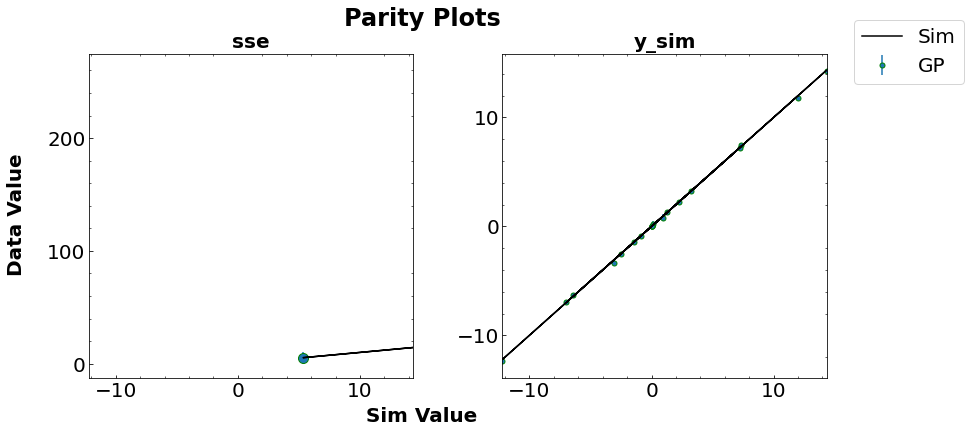

In [30]:
xbins = 5
ybins = 5

title = "Parity Plots"
x_label = "Sim Value"
y_label = "Data Value"

parity_plot(test_data, test_data_sse_data, sse_data, method, xbins, ybins, x_label, y_label, 
            title, title_fontsize, other_fontsize, save_path)

In [31]:
#Param vs y data for any value of x
#Choose a value to vary
print(simulator.theta_true_names)
vary_var = "theta_1"
#Find this paramete's index in theta_true
param_idx = simulator.theta_true_names.index(vary_var)
bounds_param = simulator.bounds_theta_reg[:,param_idx]
#Create number of points to vary
n_points = 101
#Create new theta true array of n_points
array_of_vals = np.tile(np.array(simulator.theta_true), (n_points, 1))
#Change the value of the parameter you want to vary to a linspace of n_points between the parameter bounds
varying_theta = np.linspace(bounds_param[0], bounds_param[1], n_points)
array_of_vals[:,param_idx] = varying_theta
#Give an x_value to evaluate at
x_val = exp_data.x_vals[0] 
x_data = np.vstack([x_val]*n_points)
bounds_x = simulator.bounds_x
#Create instance of Data Class
param_data = Data(array_of_vals, x_data, None, None, None, None, None, None, bounds_param, bounds_x, sep_fact, seed)
feat_param_data = gp_emulator.featurize_data(param_data)
param_data.y_vals = simulator.gen_y_data(param_data, simulator.noise_mean, simulator.noise_std)  
param_data.gp_mean, param_data.gp_var = gp_emulator.eval_gp_mean_var_misc(param_data, feat_param_data)

['theta_1', 'theta_2']


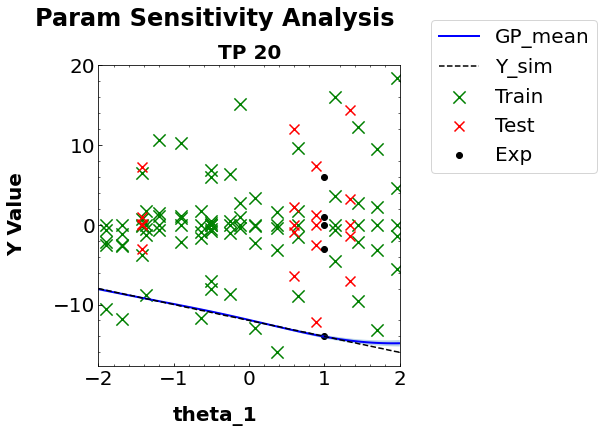

In [32]:
xbins = 5
ybins = 5

title = "Param Sensitivity Analysis"
x_label = vary_var
y_label = "Y Value"
data_names = ["TP 20"]
data = [param_data]

train_data = loaded_results[run_num].list_gp_emulator_class[bo_iter].train_data
test_data = loaded_results[run_num].list_gp_emulator_class[bo_iter].test_data

plot_theta_vs_y_given_x(data, param_idx, data_names, exp_data, train_data, test_data, xbins, ybins, title, x_label, 
                        y_label, title_fontsize, other_fontsize, save_path)